## AI model development: A clinician’s perspective   

### Building a supervised machine learning binary classification model to identify dysglycaemia using publicly available data 
    
#### *Educational resource to supplement review article "AI for the Clinical Pharmacologist: A Primer"*

#### *Model developed by Dr David Ryan*

**Disclaimer:**
This model was developed purely for educational purposes and has not been validated and should not be deployed in clinical practice. 

## Contents  

1. **Use-case**  
       1.1 Problem statements  
       1.2 Proposed solution

2. **Data source**  
       2.1 Overview: NHANES Study   
       2.2 Data acquisition  
       2.3 Excluded participants    
       2.4 Generated variables   
       2.4 Final variable list 
  
3. **Exploratory data analysis**
       3.1 Demographics 
       3.2 Description of Cohort with likely Diabetes  
       3.3 Laboratory results: exploration of correlation 
       3.4 Missing data 
       
4. **Model overview:**
       4.1 Model development plan 
       4.2 A note on class imbalance 
       4.3 Feature selection 
       4.4 Data organisation 
       
       
5. **Model building:** 
       5.1 Random forests
       5.1 Random forest with class weighting 
       5.2 Random forest with SMOTE 
       5.3 XGBoost 
       5.4 Feature importance: SHAP values 
       5.5 Model with no glycaemic traits 
       5.5 Analysis of errors
       
6. **Discussion**
       6.1 Limitations 
       6.2 Future work   

_____

## 1.0 Use-case 


### 1.1 Problem Statements

- Diabetes Mellitus is one of the most prevalent diseases in our society, affecting over 4 million people in the UK. 
- Furthermore, approximately 1 in 3 people in the UK have borderline diabetes, with many not even knowing they are at risk of developing this serious medical condition. 
- Each interaction with healthcare services can represent an opportunity for brief interventions where new diagnosis can be made or diabetes management can be optimised. 
- However, in line with growing pressures on healthcare systems, there is less time and resources available for opportunistic health screening and preventative measures. 
- In addition, adherence to treatment for diabetes can be low - with reports that adherence to medication can be as low as 36% and that adherence to insulin regiemes can be 60%. 
- There is a role to better identify patients who may have diabetes or are on sub-optimatl treatment strategies. Therefore, an automated prediction model to improve recognition of dysglycaemia, even opportunisitically, could represent a way to identify patients and improve diabetes care.


### 1.2 Proposed Solution 

- Earlier identification of dysglycaemia and recognition of poorly controlled diabetes would offer greater opportunity for targeted health interventions. 

- However, not all patients who are admitted to hospital will have a valid test for diabetes, however, most will have routine recording of other metrics - other blood tests, weight, blood pressure etc. 

- A model that could utilise routinely collected clinical data and predict probability of dysglycaemia could offer an automated recognition of people at high risk of diabetes and people with poorly controlled diabetes. 

- In this project, I will attempt to use commonly available blood test results to predict dysglycaemia. One could envisage this model being a prototype for a tool within an electronic health record - identifying people at risk of dysglycaemia and people who have sub-optimal diabetes treatment. 

- In this way, the system would provide a background safety net within an electronic health record to ensure that diabetes is appropriately managed.





_________________________________________________________________________________________________________________

## 2.0 Data Source: 
#### 2.1 Overview:  NHANES Database
The National Health and Nutrition Examination Study (NHANES) is an annual cross-sectional study conducted by the American Centre for Disease Control and Prevention (CDC). This study examines the health and nutrition of a nationally representative sample of 5, 000 non-institutionalised, civilian people living across the US. This dataset is publically available for researchers to mine and to-date thousands of studies have been based on the data produced by NHANES. 


The NHANES study has four distinct components: 
- Questionnaire regarding demographics and health status across different domains 
- Dietary (both qualitative with food diaries and quantitative with micronutrient/macronutrient quantification)
- Clinical examination (medical, dental and physiological measurements) 
- Laboratory tests 

NHANES acts as an instantaneous snapshot of people's health and allows us to draw relationships between different health metrics on a single encounter. Online there are approximately records available to download for 90,000 patients spanning from 1999 - 2016. Further details are available here: https://wwwn.cdc.gov/nchs/nhanes/

#### 2.2 Data Acquisition 
Health interviews are conducted in respondents’ homes with health measurements collected by a team of healthcare professionals in specially designed and equipped mobile centers, which travel to locations throughout the US. The study team consists of a physician, a dentist, medical and health technicians, and dietary and health interviewers. Many of the study staff are bilingual (English/Spanish). 

There are inconsistencies in what data is collected between NHANE studies - variables that are collected in one year are not always necessarily collected in other years. To account for this, I am focusing my study on laboratory data as this is the most reliable and consistent data across NHANES study. This is also the least likely to be affected by cultural and regional effects, less susceptible to changes in clinical care or treatments that occuring between 1999 - 2015 and is the most similar data that would be relevant to the practice of clinical medicine in other developed countries such as the UK. 

Data was downloaded for each NHANES study from the CDC website. This data was in the form of .XPT SAS transport files and these were converted to .csv files using the SAS Universal Viewer Programme. 

#### 2.3 Exclusion Factors 

The following participants were excluded from analysis: 
- Participants < 20 years old (reduce the risk of people with Type 1 diabetes being included in the dataset) 
- Pregnant women (reduce the risk of gestational diabetes being included in the dataset) 
- Participants who were informed that they had diabetes before the age of 20 years.  

This leaves 43,150 patients in the final dataset. 









In [1]:
#Import generic libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Import machine learning libraries 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import shap

In [296]:
#Load the dataframe
df = pd.read_csv('final_nhanes_data.csv')

In [297]:
#list of acquired variables 
list(df.columns)

['gender',
 'age',
 'ethnicity',
 'annual_household_income',
 'annual_family_income',
 'known_T2DM',
 'ldl_mmol/l',
 'hdl_mmol/l',
 'tchol_mmol/l',
 'creatinine_mg/dL',
 'hbg/dL',
 'hba1c_correct',
 'albumin_g/dl',
 'alt_u/l',
 'alp_u/l',
 'ast_u/l',
 'bicarbonate_mmol/l',
 'bun_g/dl',
 'chloride_mmol/l',
 'cholesterol_mg/dl',
 'ggt_u/l',
 'glucose_mg/dl',
 'ldh_u/l',
 'potassium_mmol/l',
 'sodium_mmol/l',
 'total_bilirubin_mg/dl ',
 'triglycerides_mg/dl',
 'weightkg',
 'bmi',
 'avg_systolic',
 'avg_diastolic',
 'Prescriptions']

In [298]:
#How big is the dataframe?
df.shape

(43150, 32)

There are 43, 150 participants and 32 variables in this dataset


#### 3.5 Generated Variables 

Some variables had to be generated. For example: 
- HbA1c > 48 as a binary variable.  
- HbA1c > 42 as a binary variable. 
- Insulin and medications were determined based on the prescription chart associated with each participant. 
- eGFR (renal function) was calculated according to Cockroft and Gault equation - using creatinine, age, gender and ethnicity. 
- Metabolic risk is a composite to identify participants who either have known T2DM or HbA1c >= 42 or high random glucose > 11.1mmol/L (200mg/dl). These would be consistent with needing further clinical work-up for a diagnosis of diabetes or pre-diabetes.

In [299]:
#High HbA1c category (split at 48mmol/L)

def hba1c_split_48(row): 
    """
    This splits HbA1c into categories according to whether it is above or below threshold of 48 mmol/L
    
    """
    if np.isnan(row['hba1c_correct']):
        return(np.nan)
    elif row['hba1c_correct'] >= 48:
        return(1)
    else: 
        return(0)

df['hba1c_48'] = df.apply(hba1c_split_48, axis=1)

In [300]:
df['hba1c_48'].value_counts(dropna=False)

0.0    32031
NaN     8155
1.0     2964
Name: hba1c_48, dtype: int64

In [301]:
#High HbA1c category (split at 42mmol/L)

def hba1c_split_42(row): 
    """
    This splits HbA1c into categories according to whether it is above or below threshold of 42 mmol/L
    
    """
    if np.isnan(row['hba1c_correct']):
        return(np.nan)
    elif row['hba1c_correct'] >= 42:
        return(1)
    else: 
        return(0)

df['hba1c_42'] = df.apply(hba1c_split_42, axis=1)

In [302]:
df['hba1c_42'].value_counts(dropna=False)

0.0    28721
NaN     8155
1.0     6274
Name: hba1c_42, dtype: int64

In [303]:
#Insulin prescribed 
df['insulin_prescribed'] = np.where(df['Prescriptions'].str.contains('INSULIN', na=False, case=False), 1, 0)

In [304]:
df['insulin_prescribed'].value_counts(dropna=False)

0    42019
1     1131
Name: insulin_prescribed, dtype: int64

I also created a column depending on whether a participant was prescribed a common form of oral anti-diabetic agent (metformin, SU, GLP agonist) 

In [305]:
#oral diabetic medication prescribed 
df['diabetic_medication'] = np.where(df['Prescriptions'].str.contains('LIRAGLUTIDE|METFORMIN|GLICLAZIDE|GILCLAZIDE|GLIPIZIDE|TOLBUTAMIDE|GILBENCLAMIDE', na=False, case=False), 1, 0)

In [306]:
df['diabetic_medication'].value_counts(dropna=False)

0    40036
1     3114
Name: diabetic_medication, dtype: int64

Renal function is commonly defined using the Cockroft and Gault Equation: 


In [307]:
#eGFR calculated 

def egfr_calculator(row): 
    
    """
    This calculates renal function according to the Cockroft and Gault Equation
    """
    
    if np.isnan(row['creatinine_mg/dL']): 
        return(np.nan)
    
    elif row['ethnicity'] == 4 and row['gender'] == 2: 
        egfr = 186*((row['creatinine_mg/dL'])**(-1.154))*((row['age'])**-0.203)*(0.742*1.212)
        return(egfr)
        
    elif row['ethnicity'] == 4: 
        egfr = 186*((row['creatinine_mg/dL'])**(-1.154))*((row['age'])**-0.203)*(1.212)
        return(egfr)
          
        
    elif row['gender'] == 2: 
        egfr = 186*((row['creatinine_mg/dL'])**(-1.154))*((row['age'])**-0.203)*(0.742)
        return(egfr)
           
    else: 
        egfr = 186*((row['creatinine_mg/dL'])**(-1.154))*((row['age'])**-0.203)
        return(egfr) 
           
          
df['eGFR']= df.apply(egfr_calculator, axis=1) 

In [308]:
df['eGFR'].describe()

count    40542.000000
mean        95.503730
std         28.155811
min          2.181060
25%         77.683824
50%         93.447434
75%        110.883456
max        394.911911
Name: eGFR, dtype: float64

In [309]:
#metabolic risk 

def metabolic_risk(row): 
    
    if (row['known_T2DM'] == 1) or (row['hba1c_42']==1) or (row['glucose_mg/dl']> 200): 
        return(1)
    else: 
        return(0)
    
df['metabolic_risk']=df.apply(metabolic_risk, axis=1)

In [310]:
df['metabolic_risk'].value_counts(dropna=False)

0    34730
1     8420
Name: metabolic_risk, dtype: int64

### Reviewing laboratory results 

Some labs have many values as 0 (which are likely missing). These need to be replaced. 

Analysis of missing values suggests I need to replace 0 to np.nan in: 
- Triglycerides, refrig serum (mg/dL)             0
- weightkg                                        0

In [311]:
df.isnull().sum()

gender                         0
age                            0
ethnicity                      0
annual_household_income     2677
annual_family_income        1891
known_T2DM                     0
ldl_mmol/l                 24253
hdl_mmol/l                  2503
tchol_mmol/l                2502
creatinine_mg/dL            2608
hbg/dL                      2027
hba1c_correct               8155
albumin_g/dl                2606
alt_u/l                     2686
alp_u/l                     6018
ast_u/l                     2691
bicarbonate_mmol/l          2676
bun_g/dl                    2610
chloride_mmol/l             2612
cholesterol_mg/dl           2614
ggt_u/l                     2612
glucose_mg/dl               2605
ldh_u/l                     2693
potassium_mmol/l            2613
sodium_mmol/l               2609
total_bilirubin_mg/dl       6057
triglycerides_mg/dl         2629
weightkg                       0
bmi                          176
avg_systolic                1781
avg_diasto

In [312]:
#clean some laboratory values 
df['triglycerides_mg/dl'].replace({0:np.nan}, inplace=True)
df['weightkg'].replace({0:np.nan}, inplace=True)

## 3.0 Exploratory Data Analysis 

### 3.1 Demographics

There are 43,150 patients in the study cohort.
  


**Table:** Descriptive Statistics 

|Demographics <img width=100/>|<img width=200/> |Number of participants<img width=200/>|
|:--|:-----|:------------------------------|
|Gender |Male <br><br> Female | 21,373 <br><br> 21,777 | 
|Ethnicity | Non-Hispanic White <br><br> Non-Hispanic Black <br><br> Mexican-American <br><br> Other Hispanic <br><br> Non-Hispanic Asian <br><br> Other Race including multi-racial <br><br> | 19, 533 <br><br> 8,975 <br><br> 7,554 <br><br> 3,542 <br><br> 1,950 <br><br> 1,596 |
|Age <br> (years) | Average: 50 <br><br> 20 - 40 years <br><br>40-60 years <br><br> 60+ years|  <br><br> 13,857 <br><br> 14,395 <br><br> 14,898 |
|BMI <br>(kg/m^2) | Average: 27.8 <br><br> Underweight (<18.5) <br><br> Normal weight (18.5 - 25) <br><br> Overweight (25 - 30) <br><br>obese (>35)|  <br><br> 708 <br><Br> 12266 <br><Br> 14664<br><Br> 15335 |
|Annual Household Income |Under 20,000 USD <br><br> 20,000 - 75,000 USD <br><br> 75,000 - 100,000 USD <br><br> Over 100,000 USD <br><br>Missing|9,223<br><br> 21,715 <br><br> 5,430 <br><br>4,105 <br><br> 2,677 |
    
   
 Table suggests that demographics are largely similar to what would be expected for a population of adults in the US.
 _____________________





In [374]:
#Cut bins to explore data in categories 
age_bins = [20, 40, 60, 100]
df['age_binned'] = pd.cut(df['age'], age_bins)
df['age_binned'].value_counts()

(20, 40]     12557
(40, 60]     12081
(60, 100]    10357
Name: age_binned, dtype: int64

In [375]:
#Cut BMI to explore data in categories 

bmi_bins = [0, 18.5, 25, 30, 100]
df['bmi_binned'] = pd.cut(df['bmi'], bmi_bins)
df['bmi_binned'].value_counts()

(30.0, 100.0]    12460
(25.0, 30.0]     12049
(18.5, 25.0]      9823
(0.0, 18.5]        557
Name: bmi_binned, dtype: int64

### 3.2 Description of Cohort with likely Diabetes  


8,420 (19.5%) have either known type 2 diabetes, pre-diabetes, or have criteria suggestive of a possible diagnosis of diabetes - random blood glucose > 11.1 or HbA1c > 48. 

In [317]:
df['metabolic_risk'].value_counts(dropna=False)

0    34730
1     8420
Name: metabolic_risk, dtype: int64

In [318]:
df.groupby(by='metabolic_risk')['age', 'bmi', 'hba1c_correct', 'avg_systolic'].mean()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,age,bmi,hba1c_correct,avg_systolic
metabolic_risk,,,,
0,48.702246,28.269966,34.835277,124.093121
1,57.347743,31.323276,51.192100,129.817751


**Table:** Participants with likely diabetes have worse health status compared to participants who are not likley to have diabetes. They are older, have higher BMI and higher average systolic blood pressure. 


**Table:** Treatment Summary for participants with high metabolic risk 

|Treatment|Number of participants in full dataset on treatment| Number of participants with Diabetes/pre-diabetes on treatments  |
|:--|:------------------------------|:----|
|No treatment |39,360 (91.21%)| 5, 916 (70.26%) |
|Oral anti-diabetic agent monotherapy|2,659 (6.16%)| 1, 683 (19.99%)|
|Insulin monotherapy | 676 (1.57%)|462 (5.49%)|
|Oral agent and insulin | 455 (1.05%) |353 (4.19%)|
|Total population | 43,150 | 8, 420|


To find the actual treatment a patient is receiving, I need a function to generate another column - note a patient can be receiving both insulin and oral medication.  

Therefore 4 possible treatment options: 
- No treatment 
- anti-diabetic oral or injectable agents only (no insulin)
- Insulin only 
- both oral/injectable agents and insulin

In [319]:
#function to create a new column with actual treatment regieme 
def actual_treatment(row): 
    """
    creates a new column with actual treatment - to account for overlap in treatment modalities 
    0 = no treatment 
    1 = oral anti-diabetic agent only 
    2 = insulin only 
    3 = both insulin and anti-diabetic agent 
    """
    if ((row['insulin_prescribed'] == 0) & (row['diabetic_medication'] == 0)): 
        return(0)
    elif ((row['insulin_prescribed'] == 0) & (row['diabetic_medication'] == 1)): 
        return(1)
    elif ((row['insulin_prescribed'] == 1) & (row['diabetic_medication'] == 0)): 
        return(2)
    elif ((row['insulin_prescribed'] == 1) & (row['diabetic_medication'] == 1)): 
        return(3)

df['actual_treatment'] = df.apply(actual_treatment, axis=1)

In [320]:
df['actual_treatment'].value_counts(dropna=False)

0    39360
1     2659
2      676
3      455
Name: actual_treatment, dtype: int64

In [321]:
df.groupby(by='metabolic_risk')['actual_treatment'].value_counts()

metabolic_risk  actual_treatment
0               0                   33444
                1                     970
                2                     214
                3                     102
1               0                    5916
                1                    1689
                2                     462
                3                     353
Name: actual_treatment, dtype: int64

This is broadly what I expected in the metabolic_risk category. 

Interestingly, there are 970 participants who do not have known diabetes or have likely diabetes on anti-diabetic medication. 
This may be due to metformin being used in alternative medical conditions (e.g. PCOS)

However, people prescribed insulin may have not responded to the T2DM question in the NHANES survey and could have good control over diabetes. This could explain the 214 people who are in the low metabolic_risk category who are prescribed insulin and the 102 people who are prescribed both insulin and tablet treatments. 

This data would not capture diet-controlled diabetes. 


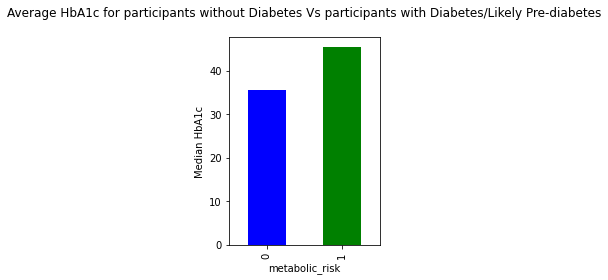

In [322]:
#compute the average HbA1c for both participants with diabetes and without 
df.groupby('metabolic_risk')['hba1c_correct'].median().plot(kind='bar', color=['blue', 'green'])
plt.title("Average HbA1c for participants without Diabetes Vs participants with Diabetes/Likely Pre-diabetes\n")
plt.ylabel('Median HbA1c');


In [323]:
#missing values for HbA1c 
df['hba1c_correct'].value_counts(dropna=False)

NaN           8155
35.505028     3426
34.411893     3341
36.598164     3220
33.318758     3062
              ... 
181.985133       1
134.980324       1
162.308701       1
167.774377       1
145.911675       1
Name: hba1c_correct, Length: 123, dtype: int64

8, 155 participants have a missing value for hba1c

invalid value encountered in greater_equal
invalid value encountered in less_equal


Text(0.5, 1.0, 'Distribution of HbA1c')

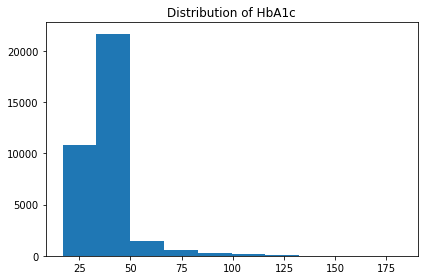

In [324]:
plt.hist(df['hba1c_correct']);
plt.title('Distribution of HbA1c')

In [325]:
#How many people in the likely diabetic category have poor control (defined as HbA1c > 48)
df.groupby('metabolic_risk')['hba1c_48'].value_counts()

metabolic_risk  hba1c_48
0               0.0         27301
1               0.0          4730
                1.0          2964
Name: hba1c_48, dtype: int64

2964 have poor control as defined by hba1c>48. 

_______

### 3.3 Laboratory Results: Exploration of Correlation


Features clustered according to major biochemical group or organ-system. Correlation with HbA1c and glucose explored through scatterplots and heatmaps. 

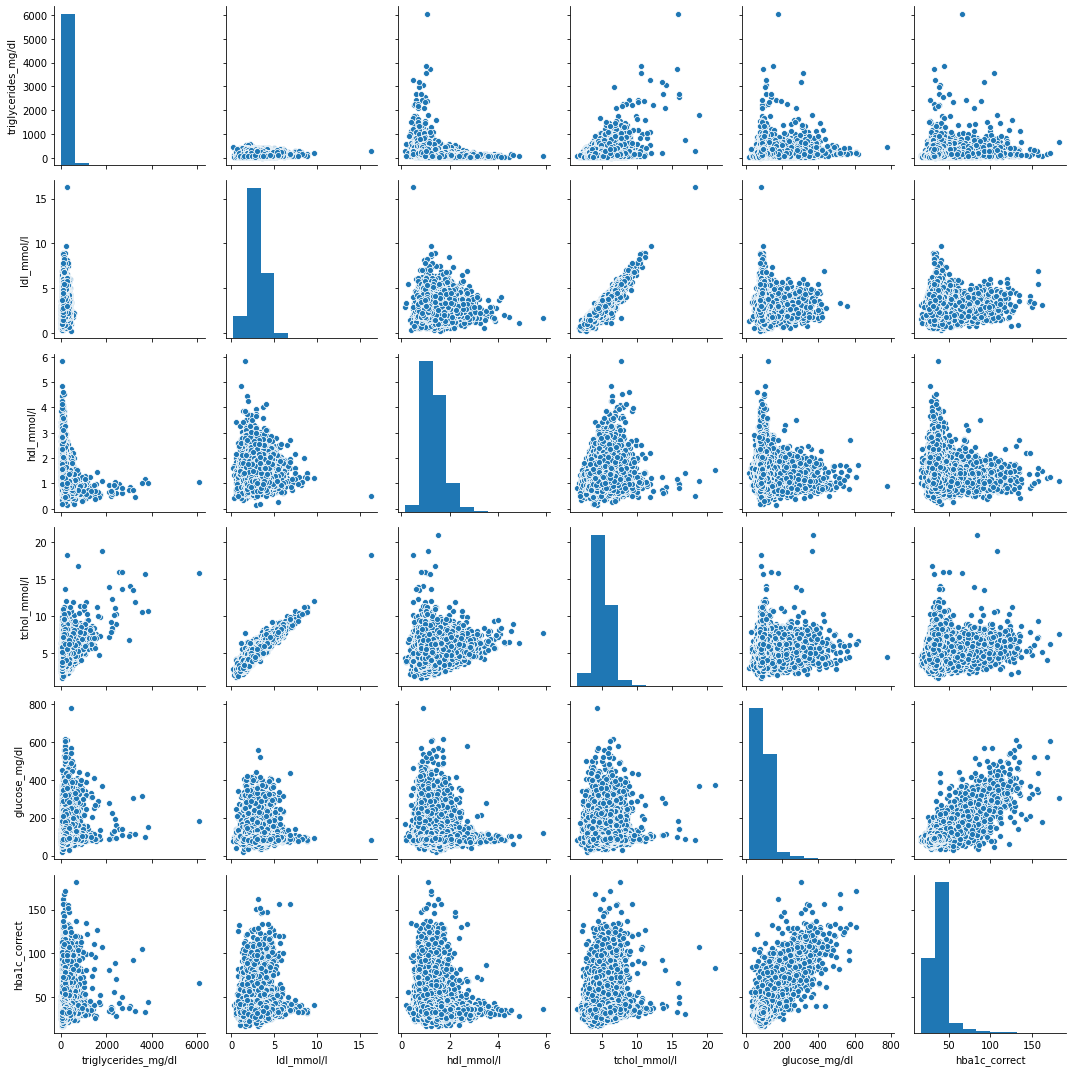

In [326]:
#lipids 
lipids = ['triglycerides_mg/dl', 'ldl_mmol/l', 'hdl_mmol/l', 'tchol_mmol/l', 'glucose_mg/dl', 'hba1c_correct']
sns.pairplot(df, vars=lipids, kind='scatter')

In [327]:
df['glucose_mg/dl'].describe()

count    40545.000000
mean       101.729288
std         37.814991
min         19.000000
25%         85.000000
50%         92.000000
75%        103.000000
max        777.000000
Name: glucose_mg/dl, dtype: float64

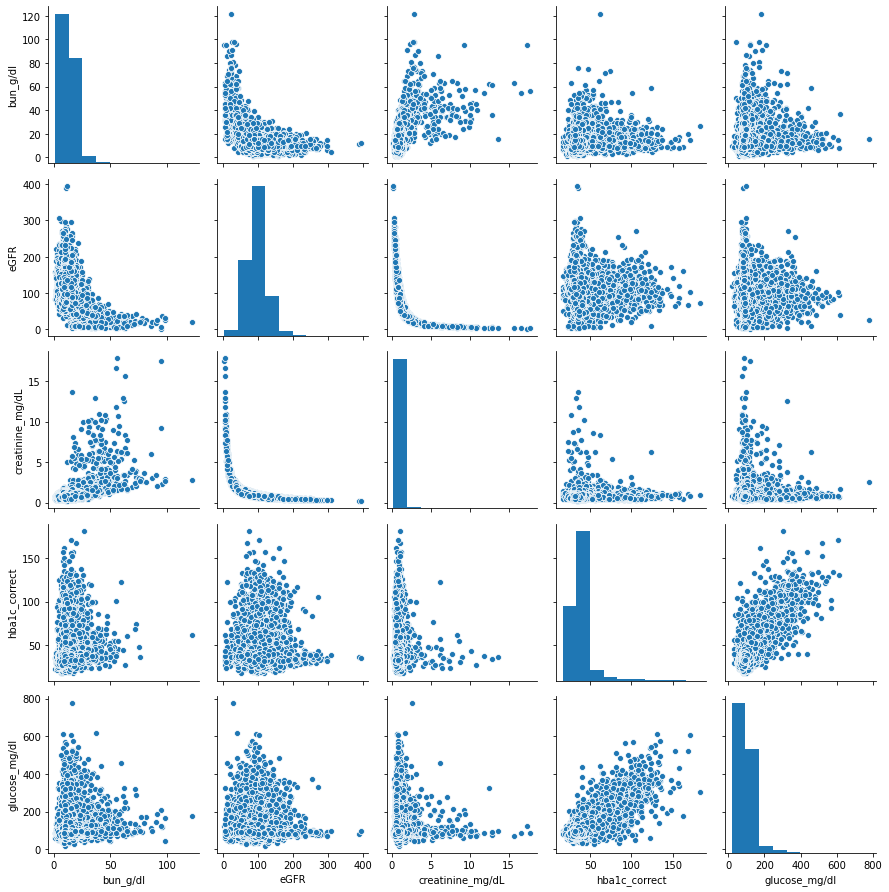

In [328]:
#kidney function 
kidney = ['bun_g/dl','eGFR', 'creatinine_mg/dL','hba1c_correct', 'glucose_mg/dl']
sns.pairplot(df, vars=kidney, kind='scatter')


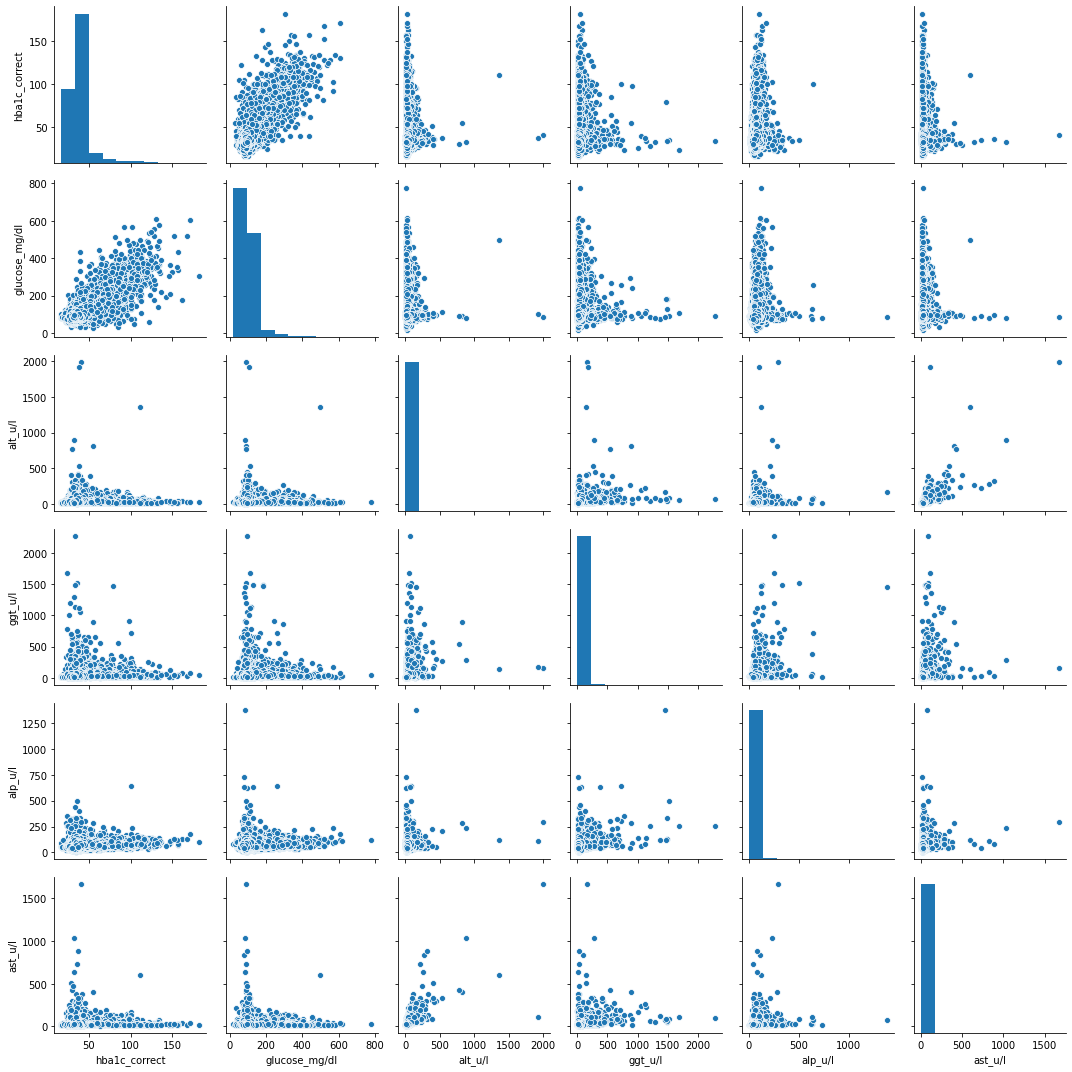

In [329]:
#liver function 
liver = ['hba1c_correct', 'glucose_mg/dl', 'alt_u/l', 'ggt_u/l', 'alp_u/l', 'ast_u/l']
sns.pairplot(df, vars=liver, kind='scatter')


Text(0.5, 1.0, 'Relationship between potassium and HbA1c ')

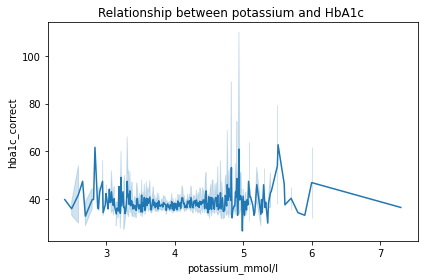

In [330]:
sns.lineplot(df['potassium_mmol/l'], df['hba1c_correct'])
plt.title("Relationship between potassium and HbA1c ")

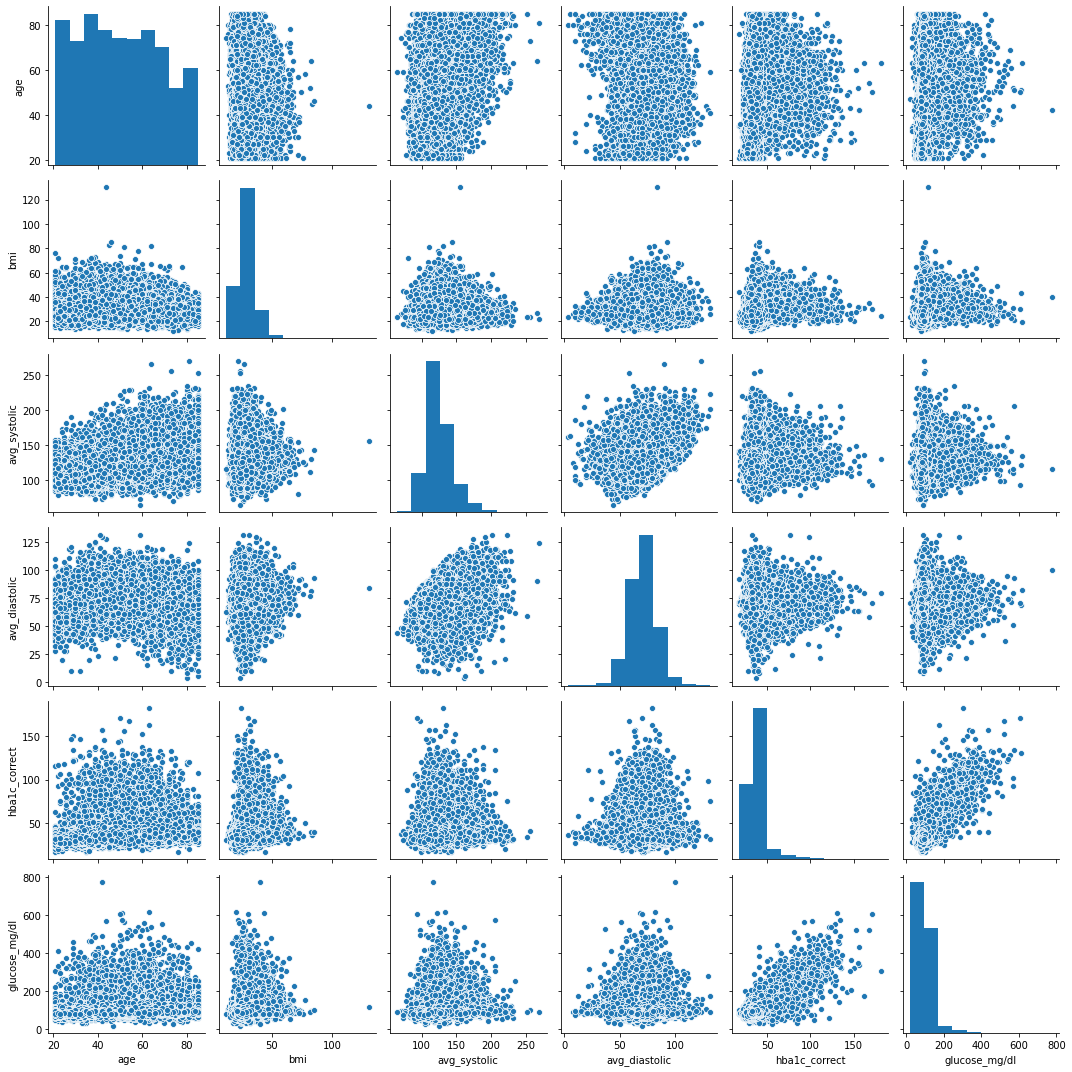

In [331]:
#measurements e.g. BP and BMI and HbA1c and glucose 
measurements = ['age', 'bmi', 'avg_systolic', 'avg_diastolic', 'hba1c_correct', 'glucose_mg/dl']
sns.pairplot(df, vars = measurements)

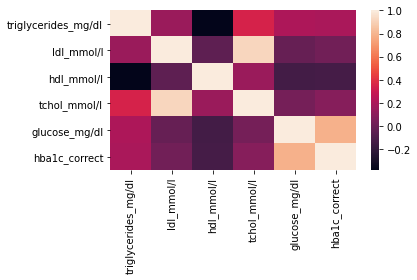

In [332]:
lipid_corr = df[lipids].corr()
sns.heatmap(lipid_corr)

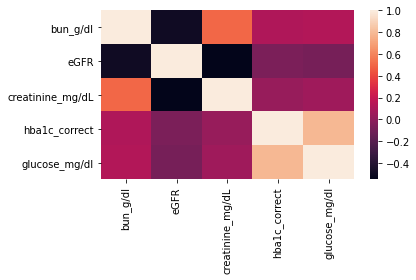

In [333]:
kidney_corr = df[kidney].corr()
sns.heatmap(kidney_corr)

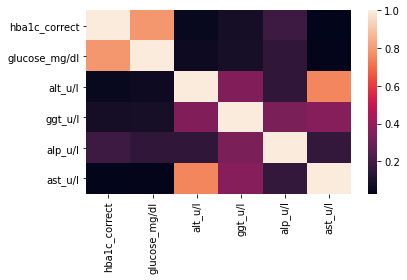

In [334]:
liver_corr = df[liver].corr()
sns.heatmap(liver_corr)

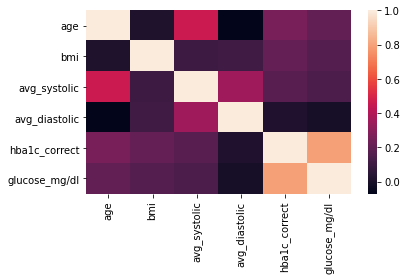

In [335]:
measurements_corr = df[measurements].corr()
sns.heatmap(measurements_corr)

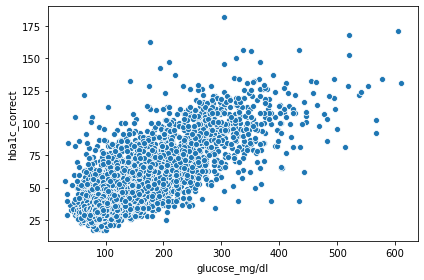

In [336]:
#relationship between glucose and hba1c 
sns.scatterplot(df['glucose_mg/dl'], df['hba1c_correct'])

________

### 3.4 Missing Data 

In [376]:
df.isnull().sum()

Unnamed: 0                     0
gender                         0
age                            0
ethnicity                      0
annual_household_income     2069
annual_family_income        1424
known_T2DM                     0
ldl_mmol/l                 18711
hdl_mmol/l                   421
tchol_mmol/l                 420
creatinine_mg/dL             509
hbg/dL                        87
hba1c_correct                  0
albumin_g/dl                 508
alt_u/l                      572
alp_u/l                     3572
ast_u/l                      577
bicarbonate_mmol/l           564
bun_g/dl                     511
chloride_mmol/l              514
cholesterol_mg/dl            515
ggt_u/l                      513
glucose_mg/dl                507
ldh_u/l                      580
potassium_mmol/l             515
sodium_mmol/l                511
total_bilirubin_mg/dl       3604
triglycerides_mg/dl          528
weightkg                       0
bmi                          106
avg_systol

Missing data will be handled by imputing an out-of-sample value (-999). Other strategies should as multiple imputation could be explored. However, if one blood test was missing - it was likely all other tests were missing - therefore, imputing may not be accurate. Similarly, missing values are likely to occur in clinical practice and therefore, accounting for this in model building seemed reasonable. 

Missing data for the target variable (i.e. HbA1c) will be dropped. 

In [338]:
#drop columns with missing target 
df.dropna(subset=['hba1c_48'], inplace=True)

In [339]:
df.shape

(34995, 41)

This results in 34, 995 remaining in the dataset. Of note - it is important to reflect on how this may bias the underlying model. For example, older people may be less likely to consent to venepuncture for NHANES study - subsequent inference from a model built using this dataset may not be as accurate for elderly people. This needs to be carefully considered. 

________

## 4. Model overview: Develop a model to identify a participant with dysglycaemia

### 4.1 Model development plan: 

**Classification problem**  

Predict whether participant has a HbA1c >=48 mmol/L 

Variables:  
- Laboratory variables 
- Demographics 
- Anthropometric variables 

Population: all participants 

**Models:** 
1. Random forest with various stragies to account for class imbalance
2. XGBoost classifier
3. Automated ML 

Rationale - these models deal with missing data, non-linear relationships and data that is not normally distributed. Previous research involving the NHANES database found that XGBoost was the most effective model to predict diabetes. 


**Schematic:**

1. Prepare dataframe and select target and features  


2. Split into train and test datasets


2. Optimise model using randomised search using cross-validation 


3. Make predictions for the test dataset (cross-validated = 5) and adjust classification using modification of probability thresholds.  


4. Evalute using confusion matrix, AUC for test dataset  


5. Compare to other models





### 4.2  A note on class imbalance

Class imbalance refers to a dataset where there is a disproportionate number of controls to cases, or vice-versa. This results in the model failing to learn in training how to distinguish between classes. This can be evident when a model predicts the majority case for all subsequent predictions. 

For example, in a task to predict a disease state where only 1% of the underlying cohort have the disease of interest. The model predicts everybody as not having the disease, returning an accuracy of 99%. In practice, the model has not learned to discriminate between cases - rather is automatically predicting the most common class as in it's training, it has not been exposed to sufficient cases. 

There are ways to address class imbalance such as Synthetic Minority Over-sampling Technique, which will be explored later. 

### 4.3 Feature selection

The following variables were used to train the model: 
- Gender 
- Age 
- Ethnicity 
- eGFR
- Hbg
- glucose_mg/dl
- potassium 
- sodium 
- alt_u/l 
- alp_u/l
- bmi 
- ave_systolic 
- avg_diastolic 
- insulin_prescribed 
- diabetic_medication 

These reflect likely information that would be available to a clerking Doctor in an acute medical unit. 

In [377]:
features = ['gender', 'age', 'ethnicity', 'eGFR', 'hbg/dL', 'glucose_mg/dl', 'potassium_mmol/l', 
            'sodium_mmol/l', 'alt_u/l', 'alp_u/l', 'bmi', 'avg_systolic', 'avg_diastolic', 'insulin_prescribed', 'diabetic_medication']

In [342]:
df.to_csv('data_for_models.csv')

### 4.4 Data organisation 

In [378]:
df = pd.read_csv('data_for_models.csv')

In [379]:
#select the target and the features 
y = df.pop('hba1c_48')
X = df[features]

In [380]:
#impute 
X.fillna(-999, inplace=True)
y.fillna(-999, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


I am imputing np.nan with -999. I previously tried imputing with mean and this provided a weaker model. I was not able to use KNN imputation as there are a lot of missing values and the imputer took a prohibitive amount of time.

An out of sample value can also be added before splitting the dataset as there is no potential leaking of information between training and testing dataset. 

In [381]:
#split train-test split stratified according to target hba1c > 48 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=123)

Data splitting was stratified to ensure that the train, validate and test datasets have the same percentage of positive and negative cases. 

Data was scaled to account for different measurement units using the mean and standard deviation of the training samples alone to avoid data leakage. 

In [382]:
#scale the data using information from the training samples only 
scaler = preprocessing.StandardScaler().fit(X_train)

In [383]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 5.0 Model building 

### 5.1 Random forest models

Decision Trees are a common ML model that classify based on separating cases (or in this context, survey participants) at various nodes according to the values of different features. The model seeks to maximise information gain at each level of the tree, splitting cases to minimise entropy and create clear distinctions between cases.

Random Forests are based on the principle of combining multiple weak base decision trees in an ensemble with sub-selection of features within each base tree to reduce model over-fitting. Hyperparameters that need to be optimised during training include, among others: 
- *n_estimators:* number of trees in the random forest 
- *max_features:* random subsets of features used in each tree 
- *max_depth:* number of splits that each decision tree is allowed to make

Hyperparameters refer to parameters that can be optimised during training. 

There are several different methods that can be employed to find the optimal hyperparameters for a model. In this project, we will be ustilising a randomized search grid which randomly passes the set of hyperparameters and calculate the score and gives the best set of hyperparameters which gives the best score as an output. Alternative approaches involve grid searches of a defined set of values for the hyperparameter in question. More detail is available on: https://scikit-learn.org/stable/modules/grid_search.html


In [384]:
#instantiate the model 
clf=RandomForestClassifier()

In [385]:
#optimise model hyperparameters using randomised search grid 

#estimators

n_estimators = list(range(1, 500, 50))

#max_features

max_features= list(range(1,50,10))

#max depth 
max_depth = list(range(1, 100, 10))

#hyperparameter dictionary 

hyperparameters = dict(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth)


In [386]:
#create randomised search model
model_optimisation = RandomizedSearchCV(clf, hyperparameters, scoring='roc_auc', n_iter=3, random_state = 123, cv=2, verbose=2)

In [387]:
best_model = model_optimisation.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_estimators=251, max_features=11, max_depth=71 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. n_estimators=251, max_features=11, max_depth=71, total=   9.9s
[CV] n_estimators=251, max_features=11, max_depth=71 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] .. n_estimators=251, max_features=11, max_depth=71, total=  10.0s
[CV] n_estimators=101, max_features=31, max_depth=71 .................
[CV] .. n_estimators=101, max_features=31, max_depth=71, total=   0.0s
[CV] n_estimators=101, max_features=31, max_depth=71 .................
[CV] .. n_estimators=101, max_features=31, max_depth=71, total=   0.0s
[CV] n_estimators=101, max_features=21, max_depth=61 .................
[CV] .. n_estimators=101, max_features=21, max_depth=61, total=   0.0s
[CV] n_estimators=101, max_features=21, max_depth=61 .................
[CV] .. n_estimators=101, max_features=21, max_depth=61, total=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.0s finished


Please note: gridsearch can be ran for further iterations to reach maximal point of optimisation. For demonstrative purposes, we will restrict our search due to limited computational power and for ease of time in an educational context.

In [388]:
#find the best parameters
best_model.best_params_

{'n_estimators': 251, 'max_features': 11, 'max_depth': 71}

In [389]:
#final model
clf=RandomForestClassifier(n_estimators=251, max_features=11, max_depth = 71, random_state=123, verbose=1)

In [390]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=71, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=1, warm_start=False)

In [391]:
#evaluate AUC on test data using 2-fold cross-validation (cv)
scores = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
print(f"average AUC with optimisation on test data: {np.mean(scores)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


average AUC with optimisation on test data: 0.955893903939726


[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished


All predictions are done using a 2-fold cross validation method. Cross-validation is a resampling method that uses different portions of the test data to determine predictions. 

In [392]:
#cross validation for predictions and probabilities using a 5-fold cross-validation
y_pred = cross_val_predict(clf, X_test, y_test, cv=5)
probs = cross_val_predict(clf, X_test, y_test, cv=5, method='predict_proba')
preds = probs[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [393]:
#create dataframe 
outcome = pd.DataFrame(y_test)
outcome.columns = ['HbA1c>48_actual']
outcome['HbA1c>48_predicted'] = y_pred

In [394]:
outcome['HbA1c>48_predicted'].value_counts(dropna=False)

0.0    8093
1.0     656
Name: HbA1c>48_predicted, dtype: int64

In [395]:
print(classification_report(outcome['HbA1c>48_actual'], outcome['HbA1c>48_predicted'], 
                            target_names=['hba1c < 48', 'hba1c > 48']))

              precision    recall  f1-score   support

  hba1c < 48       0.97      0.98      0.98      8008
  hba1c > 48       0.80      0.70      0.75       741

    accuracy                           0.96      8749
   macro avg       0.88      0.84      0.86      8749
weighted avg       0.96      0.96      0.96      8749



Confusion matrix: 

In [396]:
print(pd.DataFrame(confusion_matrix(outcome['HbA1c>48_actual'], outcome['HbA1c>48_predicted']), columns=['pred_neg', 'pred_pos'],index=['neg', 'pos']))

     pred_neg  pred_pos
neg      7874       134
pos       219       522


In [397]:
fpr, tpr, threshold = metrics.roc_curve(outcome['HbA1c>48_actual'], preds)
roc_auc = metrics.auc(fpr, tpr)

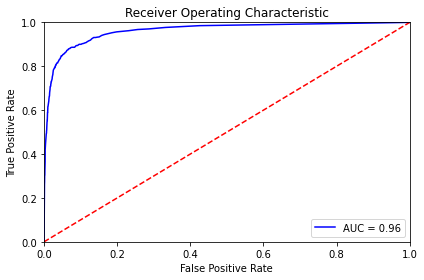

In [398]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

One can adjust the sensitivity and the specificity of the model by interrogating the effect of changing the threshold for a case being predicted. 

At a threshold of 0.15, the following results are obtained: 

In [399]:
#adjust threshold probabilities 
def adjusted_classes(y_true, t):

    return [1 if y > t else 0 for y in preds]

def precision_recall_threshold(t):
    
    y_pred_adj = adjusted_classes(preds, t)
    print('Confusion Matrix: \n')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),columns=['pred_neg', 'pred_pos'],index=['neg', 'pos']))
    print('\nClassification Report: \n')
    print(classification_report(y_test, y_pred_adj))
    
    cm1 = confusion_matrix(y_test, y_pred_adj)
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Sensitivity:', sensitivity)

In [400]:
precision_recall_threshold(0.15)

Confusion Matrix: 

     pred_neg  pred_pos
neg      7441       567
pos        88       653

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      8008
         1.0       0.54      0.88      0.67       741

    accuracy                           0.93      8749
   macro avg       0.76      0.91      0.81      8749
weighted avg       0.95      0.93      0.93      8749

Specificity :  0.9291958041958042
Sensitivity: 0.8812415654520918


Therefore, the model set at a threshold of 0.15 performs well with a sensitivity of 88.12% and specificity of 92.92%

#### Is there an optimum threshold for probability?

In this classification problem, a false negative is the worse outcome and one we wish to avoid as this would mean that a patient who has poorly controlled diabetes would be missed and not receive any medical attention. 

Therefore, we wish to reduce the false negative rate (and optimise the sensitivity). 

However, if we are overly sensitive - then we will start having too many false positives which has potentially two impacts on the system: 
- Poor utilisation of resources as too much clinical time may be spent on patients who are not requiring a review or intervention 
- "Boy who cries wolf effect" - if a system is contantly suggesting false positives - clinicians may not trust this system and not pay adequate attention to it's findings. The Emergency Care Research Institute reports that hospital alarms among the top five greatest medical technology hazards!


#### Approaches...

**1: Iterate through different thresholds and find where the maximum F1 score occurs:**


**2: Find the elbow point of false negatives with threholds:**


**3: Manual assessment and comparison with known sensitivity and specificity of other medical diagnostic tests:**   

Manual assessment of results according to different thresholds: 

In [401]:
x = []
y = []
z = []

for i in np.linspace(0,1, 100): 
    x.append(i)
    y.append(np.log(false_neg(i)))
    z.append(np.log(false_pos(i)))
    

divide by zero encountered in log


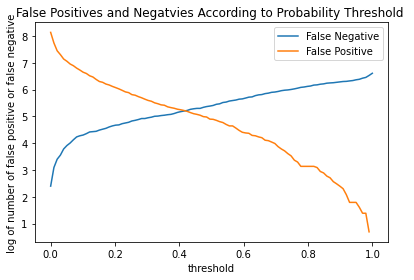

In [402]:
plt.plot(x,y, label='False Negative')
plt.plot(x,z, label='False Positive')
plt.title('False Positives and Negatvies According to Probability Threshold ')
plt.ylabel("log of number of false positive or false negative")
plt.xlabel('threshold')
plt.legend();

_____

### Random Forest accounting for class imbalance with class_weight parameter

In [403]:
#instantiate the model 
clf1=RandomForestClassifier()

I will use a randomised search grid to tune the hyper-parameters of my model:  

- n_estimators 
- max_features 
- max_depth
- class_weight 


Class_weight will test whether accounting for class imbalance will improve the model. It adds greater weight to under-represented class. 

In [404]:
#optimise model using randomised search grid  but add in class_weight parameter 

#class_weight 
class_weight = ['None','balanced_subsample', 'balanced']

#estimators

n_estimators = list(range(1, 500, 50))

#max_features

max_features= list(range(1,50,10))

#max depth 
max_depth = list(range(1, 100, 10))

#hyperparameter dictionary 

hyperparameters = dict(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth, class_weight = class_weight)


In [405]:
model_optimisation = RandomizedSearchCV(clf1, hyperparameters, scoring='roc_auc', n_iter=3, random_state = 123, cv=2, verbose=1)

In [406]:
best_model = model_optimisation.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s finished


In [407]:
best_model.best_params_

{'n_estimators': 301,
 'max_features': 1,
 'max_depth': 81,
 'class_weight': 'balanced'}

In [408]:
#instantiate the model again 
clf1=RandomForestClassifier(class_weight = 'balanced', n_estimators = 301, max_features = 1, max_depth = 81, verbose = 1, random_state=123)

In [409]:
clf1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    3.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=81, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=301,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=1, warm_start=False)

In [410]:
#evaluate AUC on test data
scores = cross_val_score(clf1, X_test, y_test, cv=2, scoring='roc_auc')
print(f"average AUC with optimisation: {np.mean(scores)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


average AUC with optimisation: 0.9617750192548036


[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.1s finished


In [411]:
#cross validation for predictions and probabilities 
y_pred = cross_val_predict(clf1, X_test, y_test, cv=5)
probs = cross_val_predict(clf1, X_test, y_test, cv=5, method='predict_proba')
preds = probs[:,1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [412]:
#create dataframe 
outcome = pd.DataFrame(y_test)
outcome.columns = ['HbA1c>48_actual']
outcome['HbA1c>48_predicted'] = y_pred

In [413]:
outcome['HbA1c>48_predicted'].value_counts(dropna=False)

0.0    8403
1.0     346
Name: HbA1c>48_predicted, dtype: int64

In [414]:
outcome['HbA1c>48_actual'].value_counts(dropna=False)

0.0    8008
1.0     741
Name: HbA1c>48_actual, dtype: int64

In [415]:
print(classification_report(outcome['HbA1c>48_actual'], 
                            outcome['HbA1c>48_predicted'], target_names=['hba1c < 48', 'hba1c > 48']))

              precision    recall  f1-score   support

  hba1c < 48       0.95      0.99      0.97      8008
  hba1c > 48       0.88      0.41      0.56       741

    accuracy                           0.95      8749
   macro avg       0.91      0.70      0.77      8749
weighted avg       0.94      0.95      0.94      8749



In [416]:
print(pd.DataFrame(confusion_matrix(outcome['HbA1c>48_actual'], outcome['HbA1c>48_predicted']), 
                   columns=['pred_neg', 'pred_pos'],index=['neg', 'pos']))


     pred_neg  pred_pos
neg      7966        42
pos       437       304


In [417]:
fpr, tpr, threshold = metrics.roc_curve(outcome['HbA1c>48_actual'], preds)
roc_auc = metrics.auc(fpr, tpr)

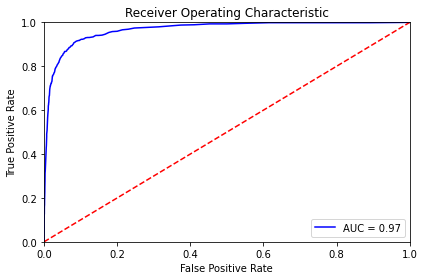

In [418]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [419]:
precision_recall_threshold(0.15)

Confusion Matrix: 

     pred_neg  pred_pos
neg      7462       546
pos        85       656

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      8008
         1.0       0.55      0.89      0.68       741

    accuracy                           0.93      8749
   macro avg       0.77      0.91      0.82      8749
weighted avg       0.95      0.93      0.94      8749

Specificity :  0.9318181818181818
Sensitivity: 0.8852901484480432


In [420]:
def adjusted_classes(y_true, t):

    return [1 if y > t else 0 for y in preds]

def false_neg(t):
    
    y_pred_adj = adjusted_classes(preds, t)
    cm = confusion_matrix(y_test, y_pred_adj)
    false_neg = cm[1][0]
    return(false_neg)


def false_pos(t):
    
    y_pred_adj = adjusted_classes(preds, t)
    cm = confusion_matrix(y_test, y_pred_adj)
    false_pos = cm[0][1]
    return(false_pos)
    

In [421]:
x = []
y = []
z = []

for i in np.linspace(0,1, 100): 
    x.append(i)
    y.append(np.log(false_neg(i)))
    z.append(np.log(false_pos(i)))
    

divide by zero encountered in log


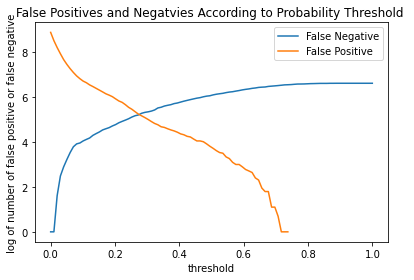

In [422]:
plt.plot(x,y, label='False Negative')
plt.plot(x,z, label='False Positive')
plt.title('False Positives and Negatvies According to Probability Threshold ')
plt.ylabel("log of number of false positive or false negative")
plt.xlabel('threshold')
plt.legend();

_______

## Does SMOTE improve the model?

Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in the dataset in a representative manner. It generates new instances from existing minority cases. 

In [423]:
#account for class imbalance with SMOTE 
smt = SMOTE()
X2_train, y2_train = smt.fit_sample(X_train, y_train)

In [424]:
#instantiate the model 
clf3=RandomForestClassifier()

In [425]:
#SMOTE has re-balanced the classes and over-sampled the under-represented class
pd.DataFrame(y2_train)['hba1c_48'].value_counts()

1.0    24023
0.0    24023
Name: hba1c_48, dtype: int64

In [426]:
#optimise model using randomised search grid  but no addition of class_weight as balanced dataset 

#estimators

n_estimators = list(range(1, 500, 50))

#max_features

max_features= list(range(1,50,10))

#max depth 
max_depth = list(range(1, 100, 10))

#hyperparameter dictionary 

hyperparameters = dict(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth)

In [427]:
model_optimisation = RandomizedSearchCV(clf3, hyperparameters, scoring='roc_auc', n_iter=3, random_state = 123, cv=2, verbose=2)

In [428]:
best_model = model_optimisation.fit(X2_train, y2_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_estimators=251, max_features=11, max_depth=71 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. n_estimators=251, max_features=11, max_depth=71, total=  28.6s
[CV] n_estimators=251, max_features=11, max_depth=71 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.6s remaining:    0.0s


[CV] .. n_estimators=251, max_features=11, max_depth=71, total=  25.6s
[CV] n_estimators=101, max_features=31, max_depth=71 .................
[CV] .. n_estimators=101, max_features=31, max_depth=71, total=   0.0s
[CV] n_estimators=101, max_features=31, max_depth=71 .................
[CV] .. n_estimators=101, max_features=31, max_depth=71, total=   0.0s
[CV] n_estimators=101, max_features=21, max_depth=61 .................
[CV] .. n_estimators=101, max_features=21, max_depth=61, total=   0.0s
[CV] n_estimators=101, max_features=21, max_depth=61 .................
[CV] .. n_estimators=101, max_features=21, max_depth=61, total=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.4s finished


Again, this should be ran for longer period of time to get most optimal result. 

In [429]:
best_model.best_params_

{'n_estimators': 251, 'max_features': 11, 'max_depth': 71}

In [431]:
#set the optimum model 
clf3=RandomForestClassifier(n_estimators = 251, max_features = 11, max_depth = 71, verbose = 1, random_state=123)

In [432]:
#train model 
clf3.fit(X2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  1.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=71, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=251,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=1, warm_start=False)

In [433]:
#evaluate AUC on test data
scores = cross_val_score(clf3, X_test, y_test, cv=2, scoring='roc_auc')
print(f"average AUC with optimisation: {np.mean(scores)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


average AUC with optimisation: 0.955893903939726


[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished


In [434]:
#cross validation for predictions and probabilities 
y_pred = cross_val_predict(clf3, X_test, y_test, cv=5)
probs = cross_val_predict(clf3, X_test, y_test, cv=5, method='predict_proba')
preds = probs[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [435]:
outcome = pd.DataFrame(y_test)
outcome.columns = ['HbA1c>48_actual']
outcome['HbA1c>48_predicted'] = y_pred

In [436]:
outcome['HbA1c>48_predicted'].value_counts(dropna=False)

0.0    8093
1.0     656
Name: HbA1c>48_predicted, dtype: int64

In [437]:
outcome['HbA1c>48_actual'].value_counts(dropna=False)

0.0    8008
1.0     741
Name: HbA1c>48_actual, dtype: int64

In [438]:
print(classification_report(outcome['HbA1c>48_actual'], outcome['HbA1c>48_predicted'], target_names=['hba1c < 48', 'hba1c > 48']))

              precision    recall  f1-score   support

  hba1c < 48       0.97      0.98      0.98      8008
  hba1c > 48       0.80      0.70      0.75       741

    accuracy                           0.96      8749
   macro avg       0.88      0.84      0.86      8749
weighted avg       0.96      0.96      0.96      8749



In [439]:
print(pd.DataFrame(confusion_matrix(outcome['HbA1c>48_actual'], outcome['HbA1c>48_predicted']), columns=['pred_neg', 'pred_pos'],index=['neg', 'pos']))


     pred_neg  pred_pos
neg      7874       134
pos       219       522


In [440]:
fpr, tpr, threshold = metrics.roc_curve(outcome['HbA1c>48_actual'], preds)
roc_auc = metrics.auc(fpr, tpr)

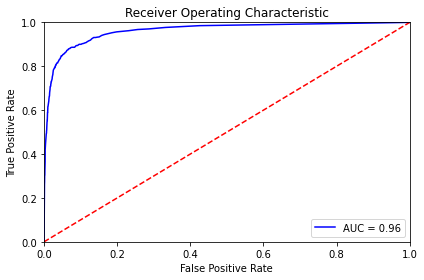

In [441]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [442]:
precision_recall_threshold(0.15)

Confusion Matrix: 

     pred_neg  pred_pos
neg      7441       567
pos        88       653

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      8008
         1.0       0.54      0.88      0.67       741

    accuracy                           0.93      8749
   macro avg       0.76      0.91      0.81      8749
weighted avg       0.95      0.93      0.93      8749

Specificity :  0.9291958041958042
Sensitivity: 0.8812415654520918


SMOTE provides similar performance to other models...

However, if I reduce the probability threshold even further to 0.15 - I can have a false negative rate of just 137 people but with 614 false positives (specificity 92% and sensitivity 80%). 

## Does Extreme Gradient Boosting improve the model? 


XGBoost stands for extreme gradient boosting and is a strategy that improves a model's accuracy. 

It is an ensemble approach that creates multiple models sequentially using the residuals or errors of prior models to inform further model development. XGBoost uses gradient descent to minimise the loss function when creating new models. In this way, the each individual decision tree in the random forest is a weak base model, but when combined with multiple other decision trees, the collective forest of models is more predictive with reduced variance. 


In [443]:
#instantiate the model 
xg_clf1 = xgb.XGBClassifier()

Hyperparameters trained for this model: 
- *n_estimators:* number of trees in the random forest 
- *subsample:* fraction of data used for each tree 
- *max_depth:* number of splits that each decision tree is allowed to make
- *scale_pos_weight*: places greater emphasis on the under-represented class - helps to account for class imbalance

There are numerous hyperparameters that can be trained, bespoke to each model and use-case. It is important to liaise with ML experts to ensure robust model development. This is for illustrative purposes:

In [444]:
#learning rate 

a = [0.001, 0.01, 0.1]

#estimators

n_estimators = list(range(1, 500, 50))

#subsample 

subsample = [0.5, 0.7, 1.0]

#max depth 
max_depth = list(range(1, 100, 10))

#scale_pos_weight 

scale_pos_weight = list(range(1,100,10))

#hyperparameter dictionary 

hyperparameters = dict(learning_rate = a, n_estimators = n_estimators, subsample = subsample,max_depth = max_depth, scale_pos_weight = scale_pos_weight)


In [445]:
xg_clf_optimisation = RandomizedSearchCV(xg_clf1, hyperparameters, n_iter=3, random_state = 123, cv=2, verbose=2)

In [446]:
best_model = xg_clf_optimisation.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01, total=  12.7s
[CV] subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01, total=  12.6s
[CV] subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001 
[CV]  subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001, total=   8.1s
[CV] subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001 
[CV]  subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001, total=   8.1s
[CV] subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01 
[CV]  subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01, total=   6.0s
[CV] subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01 
[CV]  subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01, total=   6.3s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.0s finished


In [448]:
best_model.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 41,
 'n_estimators': 451,
 'max_depth': 11,
 'learning_rate': 0.01}

In [449]:
xg_clf1 = xgb.XGBClassifier(subsample=0.5, scale_pos_weight = 41, n_estimators = 451, 
                            max_depth = 11, learning_rate = 0.01, random_state=123, verbosity=1)

In [450]:
xg_clf1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=451, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=41, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [451]:
scores = cross_val_score(xg_clf1, X_train, y_train, cv=2, scoring='roc_auc')
print(f"average AUC: {np.mean(scores)}")

average AUC: 0.9665104050805043


In [452]:
scores = cross_val_score(xg_clf1, X_test, y_test, cv=2, scoring='roc_auc')
print(f"average AUC: {np.mean(scores)}")

average AUC: 0.9620109338101251


In [269]:
#cross validation for predictions and probabilities 
y_pred = cross_val_predict(xg_clf1, X_test, y_test, cv=5)
probs = cross_val_predict(xg_clf1, X_test, y_test, cv=5, method='predict_proba')
preds = probs[:,1]

In [453]:
#create dataframe 
outcome = pd.DataFrame(y_test)
outcome.columns = ['HbA1c>48_actual']
outcome['HbA1c>48_predicted'] = y_pred

In [454]:
outcome['HbA1c>48_predicted'].value_counts(dropna=False)

0.0    8093
1.0     656
Name: HbA1c>48_predicted, dtype: int64

In [455]:
outcome['HbA1c>48_actual'].value_counts(dropna=False)

0.0    8008
1.0     741
Name: HbA1c>48_actual, dtype: int64

In [456]:
fpr, tpr, threshold = metrics.roc_curve(outcome['HbA1c>48_actual'], preds)
roc_auc = metrics.auc(fpr, tpr)

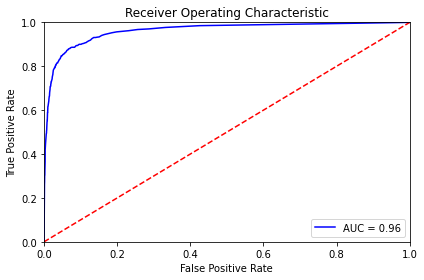

In [457]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_model1.png')


In [458]:
precision_recall_threshold(0.15)

Confusion Matrix: 

     pred_neg  pred_pos
neg      7441       567
pos        88       653

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      8008
         1.0       0.54      0.88      0.67       741

    accuracy                           0.93      8749
   macro avg       0.76      0.91      0.81      8749
weighted avg       0.95      0.93      0.93      8749

Specificity :  0.9291958041958042
Sensitivity: 0.8812415654520918


#### Results of Model 1

| Model | Train AUC | Test AUC | Probability Threshold | False Negative | False Positive | Specificity | Sensitivity
| --- | --- |--- | --- | --- |--- | --- | --- |
| Random Forest without accounting for class imbalance| 0.9495| 0.9439 | 0.2 | 169 (1.93%) | 492 (5.62%) | 93.86% | 77.19% |  
| Random Forest + class balance | 0.9512 |0.9437 | 0.2 | 193 (2.21%) | 423 (4.83%) | 94.72% | 73.95% |  
| Random Forest + SMOTE | 0.9951 | 0.9435 | 0.2 | 177 (2.02%) | 419 (4.79%) | 94.78% | 75.24% |  
| XGBoost | 0.9487 | 0.9487 | 0.35 | 132 (1.22%) | 691 (6.40%)| 91.40% | 81.54% |  


Test Population Size: 8,749

Without a measurement of glucose in the model, the most optimal model's AUC-ROC was reduced to 0.81 (test-AUC-ROC) with a resultant:

Specificity :  87%
Sensitivity:  52%




XGBoost provided a slightly improved model compared to random forest as it reduced the false negative rate with only a slight increase in false positive rates. It provided the best balance between sensitivity and specificity.


For future models I will focus on XGBoost RF classifiers. 

______________

## SHAP importance


SHAP values measure the influence of a feature by comparing model predictions with and without the feature. It takes into account the bias in classic feature importance for continuous variables. It is a method to start exploring black-box models such as XGBoost ensembles. 

In [459]:
shap.initjs()

In [460]:
explainer = shap.TreeExplainer(xg_clf1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [461]:
shap_values = explainer.shap_values(X_train, approximate=True, tree_limit=10)

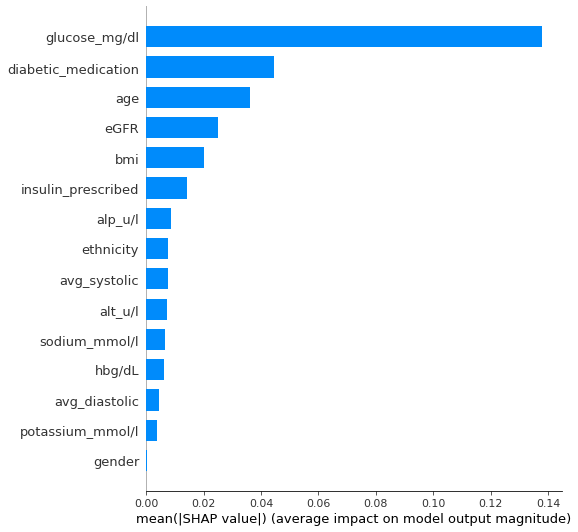

In [462]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

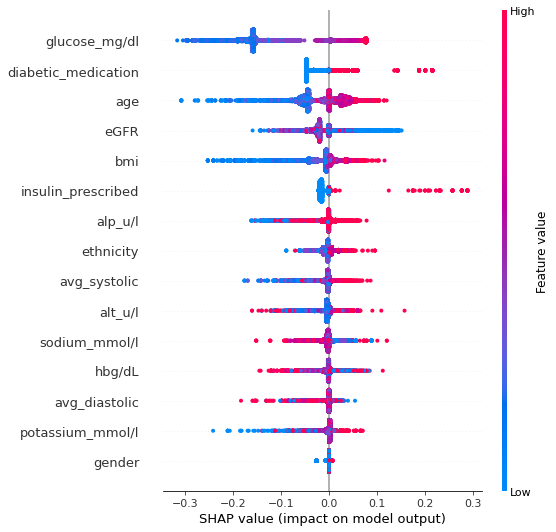

In [463]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
shap.summary_plot(shap_values, X_train, show=False, feature_names=features)
plt.savefig('shap.png')


These SHAP values suggest that this model disproportionately relies on glucose to determine who has poor diabetic control (as defined by a HbA1c > 48). Low levels of random blood glucose was strongly associated with reducing the chance of being classified as having poor control of diabetes. Higher random blood glucose was associated with increasing likelihood of being classified as having dysglycaemia, but to a lesser extend than a low blood glucose. 

Age and BMI are as expected with high age and BMI both leading to more classification in the poor control category. 

These results are largely inkeeping with clinical domain expertise. 



_______

## How predictive is the model without any measurement of glucose? 

The above model is very reliant on glucose. But how predictive is the model without any metric of glucose?

In [464]:
features_no_glucose = ['gender', 'age', 'ethnicity', 'eGFR', 'hbg/dL', 'potassium_mmol/l', 
                       'sodium_mmol/l', 'alt_u/l', 'alp_u/l', 'bmi', 'avg_systolic', 
                       'avg_diastolic', 'insulin_prescribed', 'diabetic_medication']

In [465]:
df = pd.read_csv('data_for_models.csv')

In [466]:
#select the target and the features 
y = df.pop('hba1c_48')
X = df[features_no_glucose]

In [467]:
#impute 
X.fillna(-999, inplace=True)
y.fillna(-999, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [468]:
#split train-test split 
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, stratify = y, random_state=123)

In [564]:
#scale the data using information from the training samples only 
scaler = preprocessing.StandardScaler().fit(X4_train)

In [565]:
X4_train = scaler.transform(X4_train)
X4_test = scaler.transform(X4_test)

In [471]:
#instantiate the model 
xg_clf2 = xgb.XGBClassifier()

In [472]:
#learning rate 

a = [0.001, 0.01, 0.1]

#estimators

n_estimators = list(range(1, 500, 50))

#subsample 

subsample = [0.5, 0.7, 1.0]

#max depth 
max_depth = list(range(1, 100, 10))

#scale_pos_weight 

scale_pos_weight = list(range(1,100,10))

#hyperparameter dictionary 

hyperparameters = dict(learning_rate = a, n_estimators = n_estimators, subsample = subsample,max_depth = max_depth, scale_pos_weight = scale_pos_weight)


In [473]:
xg_clf_optimisation = RandomizedSearchCV(xg_clf2, hyperparameters, n_iter=3, random_state = 123, cv=2, verbose=2)

In [474]:
best_model = xg_clf_optimisation.fit(X4_train, y4_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01, total=  12.4s
[CV] subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=41, n_estimators=451, max_depth=11, learning_rate=0.01, total=  12.3s
[CV] subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001 
[CV]  subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001, total=  10.3s
[CV] subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001 
[CV]  subsample=1.0, scale_pos_weight=81, n_estimators=201, max_depth=41, learning_rate=0.001, total=   9.9s
[CV] subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01 
[CV]  subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01, total=   7.3s
[CV] subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01 
[CV]  subsample=0.7, scale_pos_weight=91, n_estimators=151, max_depth=71, learning_rate=0.01, total=   6.9s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   59.1s finished


In [476]:
best_model.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 91,
 'n_estimators': 151,
 'max_depth': 71,
 'learning_rate': 0.01}

In [477]:
xg_clf2 = xgb.XGBClassifier(subsample=0.7, scale_pos_weight = 91, n_estimators = 151, max_depth = 71, learning_rate = 0.01, random_state=123, verbosity=1)

In [478]:
xg_clf2.fit(X4_train, y4_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=71,
              min_child_weight=1, missing=None, n_estimators=151, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=91, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [479]:
scores = cross_val_score(xg_clf2, X4_train, y4_train, cv=2, scoring='roc_auc')
print(f"average AUC: {np.mean(scores)}")

average AUC: 0.9030353456811848


In [480]:
scores = cross_val_score(xg_clf2, X4_test, y4_test, cv=2, scoring='roc_auc')
print(f"average AUC: {np.mean(scores)}")

average AUC: 0.8841613465939612


Note: performance on out-of-sample data is worse (AUC 0.9 vs 0.89). This is to be expected given that the model was built on the training data. 

In [481]:
#cross validation for predictions and probabilities 
y_pred = cross_val_predict(xg_clf2, X4_test, y4_test, cv=5)
probs = cross_val_predict(xg_clf2, X4_test, y4_test, cv=5, method='predict_proba')
preds = probs[:,1]

In [503]:
#create dataframe 
outcome = pd.DataFrame(y4_test)
outcome.columns = ['HbA1c>48_actual']
outcome['HbA1c>48_predicted'] = y_pred

In [504]:
outcome['HbA1c>48_actual'].value_counts()

0.0    8008
1.0     741
Name: HbA1c>48_actual, dtype: int64

In [505]:
outcome['HbA1c>48_predicted'].value_counts()

0.0    7950
1.0     799
Name: HbA1c>48_predicted, dtype: int64

In [485]:
fpr, tpr, threshold = metrics.roc_curve(outcome['HbA1c>48_actual'], preds)
roc_auc = metrics.auc(fpr, tpr)

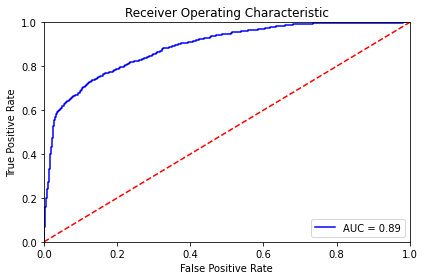

In [486]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_model4.png')


In [487]:
x = []
y = []
z = []

for i in np.linspace(0,1, 100): 
    x.append(i)
    y.append(np.log(false_neg(i)))
    z.append(np.log(false_pos(i)))
    

divide by zero encountered in log
divide by zero encountered in log


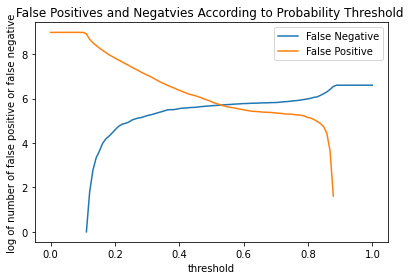

In [488]:
plt.plot(x,y, label='False Negative')
plt.plot(x,z, label='False Positive')
plt.title('False Positives and Negatvies According to Probability Threshold ')
plt.ylabel("log of number of false positive or false negative")
plt.xlabel('threshold')
plt.legend();

In [489]:
precision_recall_threshold(0.2)

Confusion Matrix: 

     pred_neg  pred_pos
neg      5504      2504
pos       100       641

Classification Report: 

              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81      8008
         1.0       0.20      0.87      0.33       741

    accuracy                           0.70      8749
   macro avg       0.59      0.78      0.57      8749
weighted avg       0.92      0.70      0.77      8749

Specificity :  0.6873126873126874
Sensitivity: 0.865047233468286


#### Exploration of SHAP values

In [490]:
explainer = shap.TreeExplainer(xg_clf2)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [491]:
shap_values = explainer.shap_values(X4_train,approximate=True, tree_limit=10)

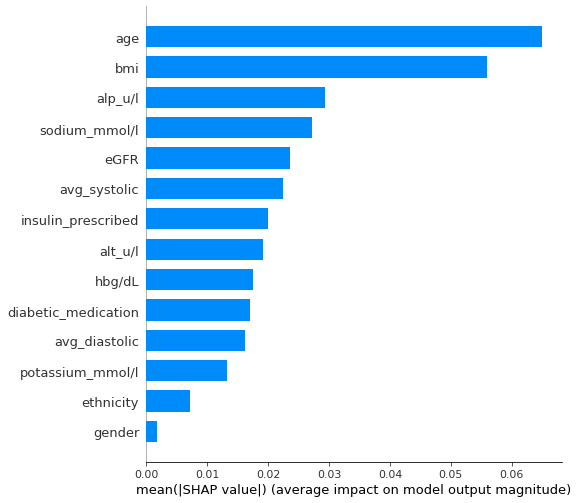

In [492]:
shap.summary_plot(shap_values, X4_train, plot_type="bar", feature_names = features_no_glucose)

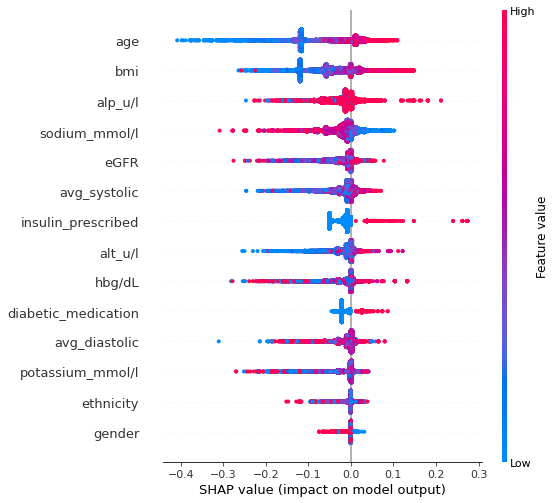

In [493]:
shap.summary_plot(shap_values, X4_train, feature_names = features_no_glucose)

As expeceted age, BMI and renal function are associated with dysglycaemia. 
Interestingly, ALP has high importance. ALP has previously been found to be increased in diabetes - although the strength of this relationship has been questioned. 

Otherwise the features are similar to model where glucose was included...

_______

## Other modelling alternatives 

**Turn this into a regression problem where HbA1c value is predicted based on the other variables.**

       - Random Forest optimised model
       - XGBoost Regressor optimised model 
       
- Advantage with regression approach is that it avoids a binary classification (there may not be much of a clinical difference between 47 and 48 mmol/L, whereas a binary model suggests that there is)

**AutomatedML - eg. AmazonML, Google automated ML products**

**Deep learning methods**

**Run models for longer with further grid searches to optimise hyperparameters** 

_____

## Limitations:

- The data orginates from a cross-sectional survey of a representative sample of the US population. Therefore, the relationships between the variables learned in this training process may not reflect real-world associations in other contexts or demographics. For example, it would be interesting to study how well the performance of such a model would be in a clinical setting where missing data may be more prevalent and acute illness may change the distribution of the included variables. 


- The glucose measurement used in this dataset was a random blood glucose tested in a laboratory. It would be interesting to assess whether these models perform with other measurements of glucose such as a finger-prick bedside test. 


- Of note, the single blood test for glucose gave the model high accuracy (in terms of both sensitivity and specificity) - perhaps this model could play a role in creating personalised thresholds for a random glucose measurement to diagnose diabetes in tandem with other clinical variables. 

- For a system that promotes saftey, false negative rate needs to be very low. In the above prototype, the best false negative rate was approx 1%. The sensitivity and specificity of these models are likely to be similar to other tests used in clinical medicine and we also need to compare the false-negative rate with human-error. 


- Temporality - the present study does not explore termporal relationship between features. Data is evaluated at a single time point. Longitudinal changes in data should be considered in further studies. 


-----------

## Future Work 

- Bayesian optimisation approach for model hyper-parameter tuning. Due to time constraint, it was not possible to tune models to fully explore a full range of parameters to tune.  
- K-fold stratification for split-test-train. 
- Divide data into train-validate-test set and use the validate set to determine the probability threshold. 
- Clinical correlation with patients who were false negatives and false positives.
- Better approach to outliers - there are suggestions that very high levels of glucose were neglected by the classifier. 
- Transfer learning approach to acute hospital setting - investigate if model performs well in other populations. External validation in other sites. 

_______

_______